# Project 1

Luke Ehrisman, Ben Williams

In [8]:
#Import block
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron as SklearnPerceptron
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from itertools import combinations
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score

In [9]:
# Import data
data = pd.read_csv('./data/processed_adult_data.csv')
X = data.drop('income', axis=1)
y = data['income']

# Part 2: Preceptron and Adaline

Test/train Split data

In [10]:
y_encoded = np.where(y == '>50K', 1, 0)
X_np = X.values.astype(np.float64)
y_np = y_encoded.astype(np.int32)

X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.2, random_state=42)

# Perceptron

In [11]:
##From: Class Notes
class Perceptron:
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        # if you use libarry versions stated by book use float_, else if new use float64
        # self.b_ = np.float_(0.)
        self.b_ = np.float64(0.)
        
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_ += update * xi
                self.b_ += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)

Train Perceptron

In [12]:
### Training the perceptron model
ppn = Perceptron(n_iter=50, eta=0.01, random_state=1)
ppn.fit(X_train, y_train)

Misclassifications for each Epoch

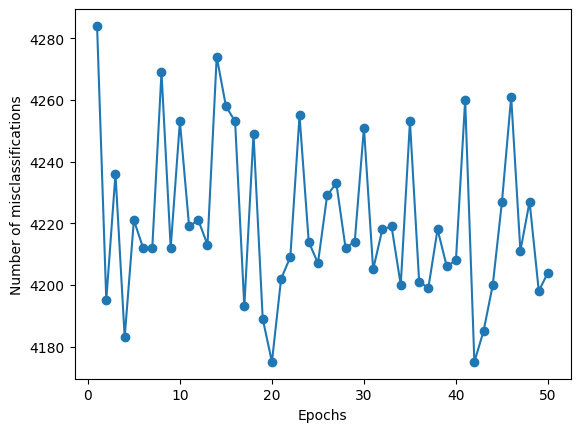

In [13]:
#From: Class Notes
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of misclassifications')

# plt.savefig('images/02_07.png', dpi=300)
plt.show()

Find a good eta and n_iter for Perceptron

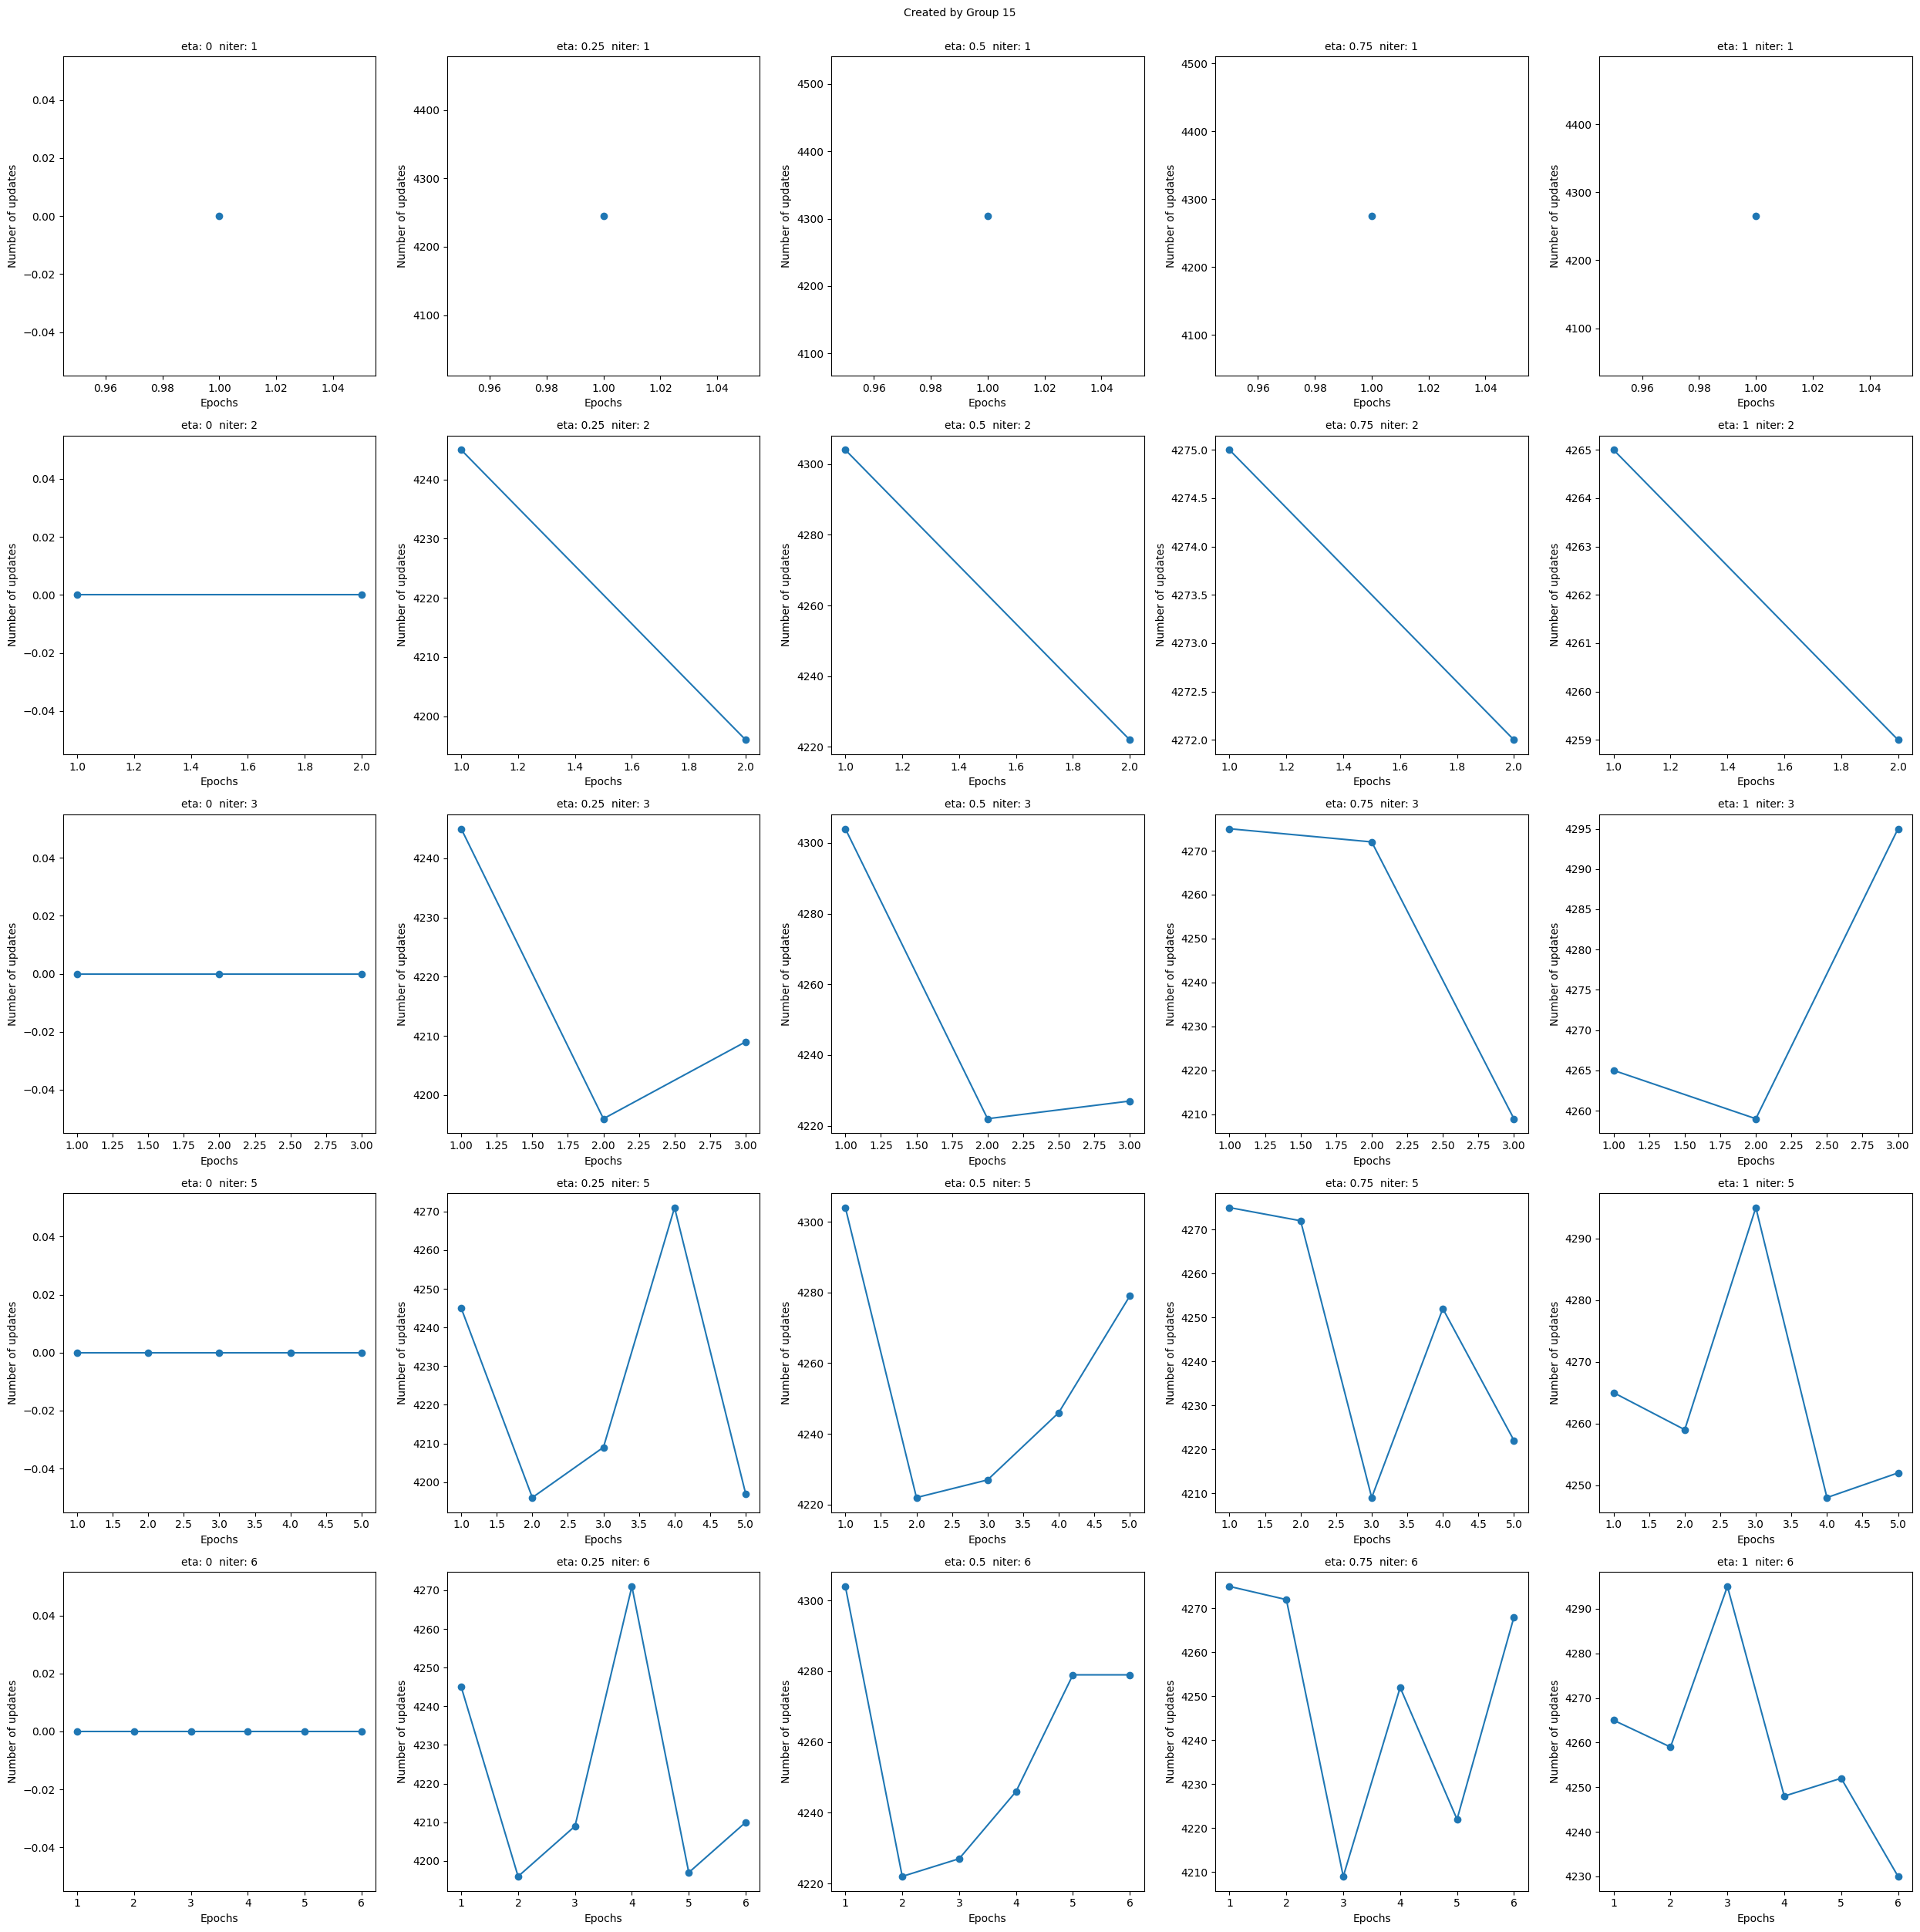

In [14]:
# Train Perceptron and find good value of eta and n_iter
#From: Class Notes
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(25, 25))

list_eta = [0, 0.25, 0.5, 0.75, 1]
list_niter = [1, 2, 3, 5, 6]

fig.suptitle("Created by Group 15", fontsize=10, y=1)

for j, n_temp in enumerate(list_niter):

    for i, e_temp in enumerate(list_eta):
        ppn = Perceptron(n_iter=n_temp, eta= e_temp).fit(X_train, y_train)
        ax[j, i].plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
        ax[j, i].set_xlabel('Epochs', fontsize=10)
        ax[j, i].set_ylabel('Number of updates', fontsize=10)
        ax[j, i].set_title(f"eta: {e_temp}  niter: {n_temp}", fontsize=10)
    
plt.tight_layout()
plt.show()

Fitting Best Model

In [15]:
ppn_best = Perceptron(eta=0.5, n_iter=5, random_state=1)
ppn_best.fit(X_train, y_train)

Accuracy Score for Best Model PPN

In [16]:
y_test_pred = ppn_best.predict(X_test)
accuracy_ppn = accuracy_score(y_test, y_test_pred)
print(f"Accuracy Score for Best Model Perceptron: {accuracy_ppn:.4f}")

Accuracy Score for Best Model Perceptron: 0.8223


Process Validation data

In [17]:
validation_data = pd.read_csv('data/processed_validation_inputs.csv')
X_validation = validation_data.copy()

# Add missing columns with value 0.0
missing_cols = ['workclass_Never-worked', 'native-country_Holand-Netherlands', 'native-country_Outlying-US(Guam-USVI-etc)']
for col in missing_cols:
    X_validation[col] = 0.0

# Predict
predictions = ppn.predict(X_validation)

# Save and Report Predictions
predictions_labels = np.where(predictions == 1, '>50K', '<=50K')

# Create a DataFrame for the predictions
output_df = pd.DataFrame({
    "Index": validation_data.index,
    "Predicted_Response": predictions_labels
})

# Save the predictions to a CSV file
file_name = "./predictions/Group_15_Perceptron_PredictedOutputs.csv"
output_df.to_csv(file_name, index=False)
print(f"Predictions saved to {file_name} (index + prediction only)")
output_df.head()

Predictions saved to ./predictions/Group_15_Perceptron_PredictedOutputs.csv (index + prediction only)


,Index,Predicted_Response
0,0,<=50K
1,1,<=50K
2,2,<=50K
3,3,<=50K
4,4,<=50K


# Adaline

In [18]:
#From: Class Notes
class AdalineSGD:
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    shuffle : bool (default: True)
      Shuffles training data every epoch if True to prevent cycles.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
        Bias unit after fitting.
    losses_ : list
      Mean squared error loss function value averaged over all
      training examples in each epoch.

        
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.losses_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses = []
            for xi, target in zip(X, y):
                losses.append(self._update_weights(xi, target))
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=m)
        self.b_ = np.float64(0.)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_ += self.eta * 2.0 * xi * (error)
        self.b_ += self.eta * 2.0 * error
        loss = error**2
        return loss
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

Train Adaline

/var/folders/lm/4kyv9_wd0dq69x6yy9fvmw5h0000gn/T/ipykernel_50203/554470097.py:94: RuntimeWarning: overflow encountered in scalar power
  loss = error**2
/Users/lukehrisman/UARK - Machine Learning/pyml-book/lib/python3.13/site-packages/numpy/_core/_methods.py:134: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


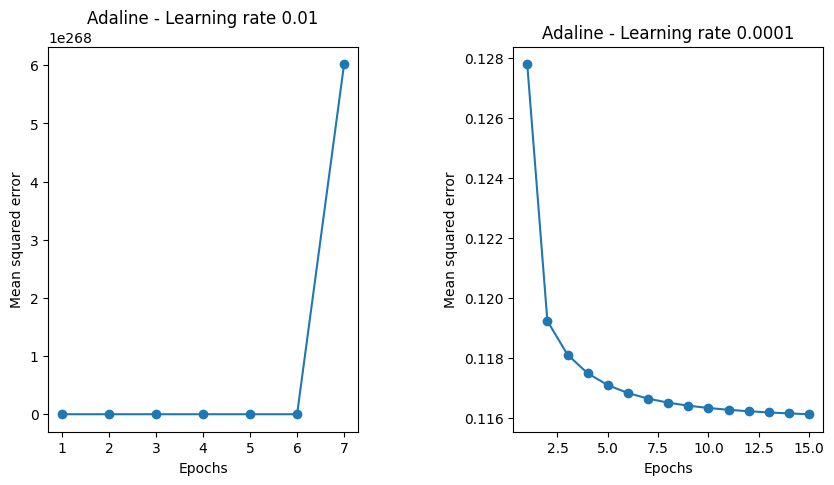

In [19]:
# Train adaptive linear neuron with AdalineSGD with 2 different learning rates.....without shuffling 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ada1 = AdalineSGD(n_iter=15, eta=0.01, shuffle=False).fit(X_train, y_train)
ax[0].plot(range(1, len(ada1.losses_) + 1), ada1.losses_, marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Mean squared error')
ax[0].set_title('Adaline - Learning rate 0.01')

ada2 = AdalineSGD(n_iter=15, eta=0.0001, shuffle=False).fit(X_train, y_train)
ax[1].plot(range(1, len(ada2.losses_) + 1), ada2.losses_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Mean squared error')
ax[1].set_title('Adaline - Learning rate 0.0001')

# Adjust the horizontal space between subplots
plt.subplots_adjust(wspace=0.5)

# plt.savefig('images/02_11.png', dpi=300)
plt.show()

Find accuracy for best model

In [20]:
# predict on trained AdalineSGD models with shuffle FALSE
y_pred =ada1.predict(X_test)
print(f"Adaline accuracy with n_iter 15 and eta 0.1: {accuracy_score(y_test, y_pred):.4f}")

y_pred =ada2.predict(X_test)
ada_score = accuracy_score(y_test, y_pred)
print(f"Adaline accuracy with n_iter 15 and eta 0.0001: {ada_score:.4f}")

Adaline accuracy with n_iter 15 and eta 0.1: 0.5019
Adaline accuracy with n_iter 15 and eta 0.0001: 0.8434


Validation data

In [21]:
validation_data = pd.read_csv('data/processed_validation_inputs.csv')
X_validation = validation_data.copy()

# Add missing columns with value 0.0
missing_cols = ['workclass_Never-worked', 'native-country_Holand-Netherlands', 'native-country_Outlying-US(Guam-USVI-etc)']
for col in missing_cols:
    X_validation[col] = 0.0

# Predict adaline
predictions = ada1.predict(X_validation)

# Save and Report Predictions
predictions_labels = np.where(predictions == 1, '>50K', '<=50K')

# Create a DataFrame for the predictions
output_df = pd.DataFrame({
    "Index": validation_data.index,
    "Predicted_Response": predictions_labels
})

# Save the predictions to a CSV file
file_name = "./predictions/Group_15_Adaline_PredictedOutputs.csv"
output_df.to_csv(file_name, index=False)
print(f"Predictions saved to {file_name} (index + prediction only)")
output_df.head()

Predictions saved to ./predictions/Group_15_Adaline_PredictedOutputs.csv (index + prediction only)


,Index,Predicted_Response
0,0,>50K
1,1,<=50K
2,2,>50K
3,3,<=50K
4,4,<=50K


# Part 2: Comparison

In [22]:
# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Assumption:  This code assumes you have already clean, processed, and split a data set.
'''
Input Data Required:
X_train = cleaned, processed input data for training prediction models
y_train = response variable associated with X_train; truth values
X_test = cleaned, processed input data for testing prediction model created on training dataset
y_test = response variable associated with X_test; truth values

Note: Current order of rows ensure y_train = X_train and y_test = X_test, but if you sort and remove rows this association changes.
'''
# Scikit-learn Perceptron
sk_ppn = SklearnPerceptron(eta0=0.1, max_iter=15, random_state=42)
sk_ppn.fit(X_train, y_train)
sk_y_pred_ppn = sk_ppn.predict(X_test)
sk_ppn_score = accuracy_score(y_test, sk_y_pred_ppn)

# Scikit-learn Adaline (using SGDClassifier with 'log_loss' is closer, but 'perceptron' is available)
# For Adaline (which uses GD), SGDClassifier with 'hinge' loss is a good proxy, as it's a linear classifier with regularization
sk_ada = SGDClassifier(loss='perceptron', eta0=0.0001, learning_rate='constant', max_iter=15, random_state=42)
sk_ada.fit(X_train, y_train)
sk_y_pred_ada = sk_ada.predict(X_test)
sk_ada_score = accuracy_score(y_test, sk_y_pred_ada)

print("--- Perceptron ---")
print(f"Scikit-learn Perceptron accuracy: {sk_ppn_score:.4f}%")
print(f"Custom Perceptron Score for (Best Model): {accuracy_ppn:.4f}%")
print("--- Adaline ---")
print(f"Scikit-learn Adaline (SGDClassifier) accuracy: {sk_ada_score:.4}%")
print(f"Custom Adaline accuracy (Best Model): {ada_score:.4f}%")

--- Perceptron ---
Scikit-learn Perceptron accuracy: 0.8177%
Custom Perceptron Score for (Best Model): 0.8223%
--- Adaline ---
Scikit-learn Adaline (SGDClassifier) accuracy: 0.8092%
Custom Adaline accuracy (Best Model): 0.8434%


# Part 3: Logistic Regression model and Support Vector Machine

Code to train, test, validate, and visualize

In [23]:
#Plot confusion matrix function definition
##From: Class notes
def plot_confusion_matrix(cm, y_true):
    """
    Plots the confusion matrix using a heatmap.

    Args:
        cm (np.ndarray): The confusion matrix.
        y_true (np.ndarray): The true labels for the test data.
    """
    # Create the plot using pure matplotlib
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Use imshow to create the heatmap
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the unique class names
           xticklabels=np.unique(y_true), yticklabels=np.unique(y_true),
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

# Logistic Regression

In [24]:
#LR Data split
##From: Class notes
# Split data into training and test sets
# Can specify same proportion of classes in both sets with stratify=y
X_LR_train, X_LR_test, y_LR_train, y_LR_test = train_test_split(X, y, test_size=0.25, random_state= 221125, stratify=y)

In [25]:
#Train LR Model with GridSearchCV
##From: Class notes
"""
Changed the number of iterations to 300 and number of folds to 10
to ensure convergence since this dataset is larger and more complex.
"""
# We use GridSearchCV to find the best hyperparameters for the model.
# Cross-validation (CV) helps to get a more robust estimate of model performance
# and prevents overfitting to a single train-test split.

# Define the parameter grid to search over.
# np.logspace(-4,4,2-) tells GridSearchCV to test 20 values for C eenly spaced on logarithmic scale from 10^-4 to 10^4
param_grid = {
    'C': np.logspace(-4, 4, 20),  # Inverse of regularization strength
}

# Initialize GridSearchCV with a 5-fold cross-validation strategy.
grid_search = GridSearchCV(
    estimator=LogisticRegression(solver='lbfgs', random_state=221125, max_iter=300),
    param_grid=param_grid,
    cv=10,                    # 10*-fold cross-validation
    scoring='accuracy',       # Metric to optimize for
    n_jobs=-1,                # Use all available CPU cores
    verbose=1                 # Print progress
)

print("Starting hyperparameter search. This may take a moment...")
grid_search.fit(X_LR_train, y_LR_train.values.ravel())

Starting hyperparameter search. This may take a moment...
Fitting 10 folds for each of 20 candidates, totalling 200 fits


Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /var/folders/lm/4kyv9_wd0dq69x6yy9fvmw5h0000gn/T/joblib_memmapping_folder_50203_e7bfdc45e2514d43ba5f77255c9f3c73_4e29655659364cf0b08edf96d8b0a574 for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /loky-50203-2gqhyvs3 for automatic cleanup: unknown resource type semlock
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/

,estimator,LogisticRegre..._state=221125)
,param_grid,{'C': array([1.0000...00000000e+04])}
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,10
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'



--- Best Model Found by GridSearchCV ---
Best parameters: {'C': np.float64(11.288378916846883)}
Best cross-validation accuracy: 0.8516

 Final evaluation of the best model on the test set...
Final accuracy on test set: 0.8497

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90      4944
        >50K       0.73      0.60      0.66      1568

    accuracy                           0.85      6512
   macro avg       0.80      0.76      0.78      6512
weighted avg       0.84      0.85      0.84      6512


Confusion Matrix:
[[4598  346]
 [ 633  935]]


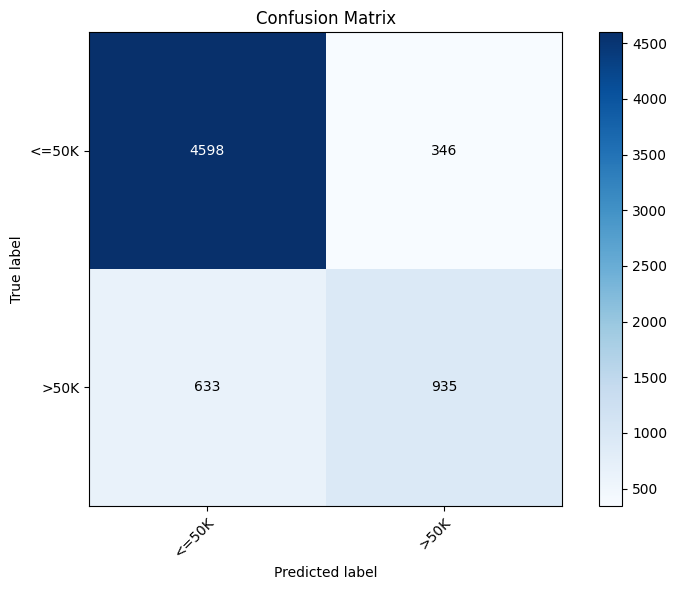

In [26]:
#Best estimator, confusion matrix, and classification report
##From: Class notes
# Get the best estimator from the search.
best_model = grid_search.best_estimator_

print("\n--- Best Model Found by GridSearchCV ---")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

print("\n Final evaluation of the best model on the test set...")
# Predict using the best model found during the search.
final_y_pred = best_model.predict(X_LR_test)
final_accuracy = accuracy_score(y_LR_test, final_y_pred)

print(f"Final accuracy on test set: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_LR_test, final_y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_LR_test, final_y_pred)
print(cm)

# Plot the predictions and the confusion matrix
plot_confusion_matrix(cm, y_LR_test)

In [27]:
#Plot decision boundary function definition
##From: Class notes (adapted from SVM decision boundary plot function)
def plot_best_LogReg_decision_boundary(grid_search, X, y):
    """
    Plots the decision boundaries for the best Logistic Regression model found by GridSearchCV.

    Args:
        grid_search (GridSearchCV): The fitted GridSearchCV object.
        X (pd.DataFrame): The input features (must be a DataFrame for feature names).
        y (pd.Series or np.ndarray): The target labels.
    """
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Standardize the y input and encode if necessary
    if isinstance(y, pd.DataFrame):
        if y.shape[1] != 1:
            raise ValueError("If 'y' is a DataFrame, it must contain a single column.")
        y_series = y.iloc[:, 0]
    elif isinstance(y, (pd.Series, np.ndarray)):
        y_series = pd.Series(y).ravel()
    else:
        raise TypeError("y must be a pandas DataFrame, Series, or a NumPy array.")
    
    if y_series.dtype == 'object':
        print("Encoding string labels to numerical format...")
        le = LabelEncoder()
        y_encoded = le.fit_transform(y_series)
    else:
        y_encoded = y_series.values

    n_features = X.shape[1]
    if n_features < 2:
        raise ValueError("This function requires at least 2 features for plotting combinations.")

    feature_pairs = list(combinations(range(n_features), 2))
    n_pairs = len(feature_pairs)
    
    fig, axes = plt.subplots(1, n_pairs, figsize=(n_pairs * 8, 6), constrained_layout=True)

    # Ensure axes is an array even for a single subplot
    if n_pairs == 1:
        axes = [axes]

    for j, (f1_idx, f2_idx) in enumerate(feature_pairs):
        ax = axes[j]
        
        # Select the two features for the current plot
        X_pair = X.iloc[:, [f1_idx, f2_idx]]
        f1_name = X.columns[f1_idx]
        f2_name = X.columns[f2_idx]

        # Use the best model from GridSearchCV
        model = best_model
        
        # Since the best model was trained on the full dataset, we'll retrain
        # a new instance of it on just the two features for plotting purposes.
        # This is the most reliable way to ensure the decision boundary is correct.
        plot_model = LogisticRegression(
            C=best_params.get('C'),
            solver=best_params.get('solver', 'lbfgs')
        )
        plot_model.fit(X_pair.values, y_encoded)
        
        # Plot the data points
        ax.scatter(X_pair.iloc[:, 0], X_pair.iloc[:, 1], c=y_encoded, cmap=plt.cm.coolwarm, s=10)

        # Create and plot the decision boundary
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 500),
                             np.linspace(ylim[0], ylim[1], 500))
        Z = plot_model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
        
        # Highlight the support vectors
        #ax.scatter(plot_model.support_vectors_[:, 0], plot_model.support_vectors_[:, 1], s=50,
                   #linewidth=1, facecolors='none', edgecolors='k')
        
        # Set titles and labels
        ax.set_xlabel(f1_name)
        ax.set_ylabel(f2_name)
        ax.set_aspect('equal', adjustable='box')

    plt.suptitle(f"GridSearchCV Best Model Decision Boundaries\nBest Params: {best_params}", y=1.05)
    plt.show()

In [28]:
#Select values from hours-per-week and education-num for x and y axis
log_num = X_LR_train[['education-num', 'hours-per-week']]

Encoding string labels to numerical format...


/var/folders/lm/4kyv9_wd0dq69x6yy9fvmw5h0000gn/T/ipykernel_50203/2476088435.py:21: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_series = pd.Series(y).ravel()


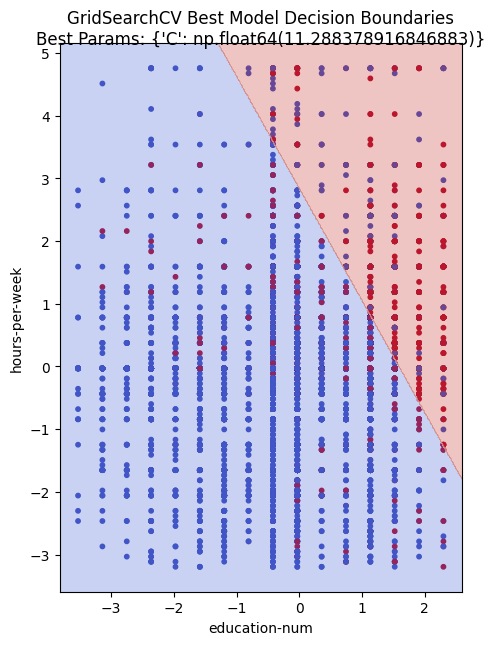

In [29]:
#Plot decision boundary for best LR model
plot_best_LogReg_decision_boundary(grid_search, log_num, y_LR_train)

In [30]:
#Run LR model with different C values
C_values = [0.01, 1.0, 100.0]
print("Logistic Regression Accuracy with different C values:")
for C in C_values:
    log_reg = LogisticRegression(C=C, solver='lbfgs', max_iter=300, random_state=221125)
    log_reg.fit(X_LR_train, y_LR_train.values.ravel())
    y_pred = log_reg.predict(X_LR_test)
    acc = accuracy_score(y_LR_test, y_pred)
    print(f"C={C:<6} -> Accuracy: {acc:.4f}")


Logistic Regression Accuracy with different C values:
C=0.01   -> Accuracy: 0.8428
C=1.0    -> Accuracy: 0.8497
C=100.0  -> Accuracy: 0.8497


In [31]:
#Predicting on Validation Dataset using Best LR Model

#Load validation dataset
validation_df = pd.read_csv("./data/processed_validation_inputs.csv")

#Get the training columns
LR_train_columns = X_LR_train.columns

#Reindex validation to match training columns. Fill missing with 0
#Fixes issue where validation doesn't contain the same one-hot encoded columns as training data
X_val_encoded = validation_df.reindex(columns=LR_train_columns, fill_value=0)

#Ensure the order of columns matches
X_val_encoded = X_val_encoded[LR_train_columns]

#Generate predictions using the trained LR model
predictions = best_model.predict(X_val_encoded)

#Create a DataFrame with just index and predictions
output_df = pd.DataFrame({
    "Index": validation_df.index,
    "Predicted_Response": predictions
})

#Save to a new CSV file
output_df.to_csv("./predictions/Group_15_LogisticRegression_PredictedOutputs.csv", index=False)

#Report
print("Predictions saved to ./predictions/Group_15_LogisticRegression_PredictedOutputs.csv (index + prediction only)")

Predictions saved to ./predictions/Group_15_LogisticRegression_PredictedOutputs.csv (index + prediction only)


# SVM

In [32]:
#Plot SVM decision boundary function definition
##From: Class notes
def plot_best_svm_decision_boundary(grid_search, X, y):
    """
    Plots the decision boundaries for the best SVM model found by GridSearchCV.

    Args:
        grid_search (GridSearchCV): The fitted GridSearchCV object.
        X (pd.DataFrame): The input features (must be a DataFrame for feature names).
        y (pd.Series or np.ndarray): The target labels.
    """
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_kernel = best_params.get('kernel', 'linear') # Default to linear if not found

    # Standardize the y input and encode if necessary
    if isinstance(y, pd.DataFrame):
        if y.shape[1] != 1:
            raise ValueError("If 'y' is a DataFrame, it must contain a single column.")
        y_series = y.iloc[:, 0]
    elif isinstance(y, (pd.Series, np.ndarray)):
        y_series = pd.Series(y).ravel()
    else:
        raise TypeError("y must be a pandas DataFrame, Series, or a NumPy array.")
    
    if y_series.dtype == 'object':
        print("Encoding string labels to numerical format...")
        le = LabelEncoder()
        y_encoded = le.fit_transform(y_series)
    else:
        y_encoded = y_series.values

    n_features = X.shape[1]
    if n_features < 2:
        raise ValueError("This function requires at least 2 features for plotting combinations.")

    feature_pairs = list(combinations(range(n_features), 2))
    n_pairs = len(feature_pairs)
    
    fig, axes = plt.subplots(1, n_pairs, figsize=(n_pairs * 8, 6), constrained_layout=True)

    # Ensure axes is an array even for a single subplot
    if n_pairs == 1:
        axes = [axes]

    for j, (f1_idx, f2_idx) in enumerate(feature_pairs):
        ax = axes[j]
        
        # Select the two features for the current plot
        X_pair = X.iloc[:, [f1_idx, f2_idx]]
        f1_name = X.columns[f1_idx]
        f2_name = X.columns[f2_idx]

        # Use the best model from GridSearchCV
        model = best_model
        
        # Since the best model was trained on the full dataset, we'll retrain
        # a new instance of it on just the two features for plotting purposes.
        # This is the most reliable way to ensure the decision boundary is correct.
        plot_model = SVC(
            kernel=best_params.get('kernel'),
            C=best_params.get('C'),
            gamma=best_params.get('gamma')
        )
        if best_kernel == 'poly':
            plot_model.degree = best_params.get('degree', 3) # Handle poly degree separately
        plot_model.fit(X_pair.values, y_encoded)
        
        # Plot the data points
        ax.scatter(X_pair.iloc[:, 0], X_pair.iloc[:, 1], c=y_encoded, cmap=plt.cm.coolwarm, s=10)

        # Create and plot the decision boundary
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 500),
                             np.linspace(ylim[0], ylim[1], 500))
        Z = plot_model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
        
        # Highlight the support vectors
        ax.scatter(plot_model.support_vectors_[:, 0], plot_model.support_vectors_[:, 1], s=50,
                   linewidth=1, facecolors='none', edgecolors='k')
        
        # Set titles and labels
        ax.set_title(f"Best Model ({best_kernel.capitalize()} kernel)\n({f1_name} vs {f2_name})")
        ax.set_xlabel(f1_name)
        ax.set_ylabel(f2_name)
        ax.set_aspect('equal', adjustable='box')

    plt.suptitle(f"GridSearchCV Best Model Decision Boundaries\nBest Params: {best_params}", y=1.05)
    plt.show()

In [33]:
#SVM Data split
##From: Class notes
# split data into training and test datasets
# can specify same proportion of classes in both sets with stratify=y
X_SVM_train, X_SVM_test, y_SVM_train, y_SVM_test = train_test_split(X, y, test_size=0.25, random_state=21125, stratify=y)

In [34]:
#Train SVM Model with GridSearchCV
##From: Class notes
# We use GridSearchCV to find the best hyperparameters for the model.
# Cross-validation (CV) helps to get a more robust estimate of model performance
# and prevents overfitting to a single train-test split.

# Define the parameter grid to search over.
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}


# Initialize GridSearchCV with a 5-fold cross-validation strategy.
grid_search = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    cv=5,                     # 5-fold cross-validation
    scoring='accuracy',       # Metric to optimize for
    n_jobs=-1,                # Use all available CPU cores
    verbose=1                 # Print progress
)

print("Starting hyperparameter search. This may take a moment...")
grid_search.fit(X_SVM_train, y_SVM_train.values.ravel())

Starting hyperparameter search. This may take a moment...
Fitting 5 folds for each of 18 candidates, totalling 90 fits


Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /var/folders/lm/4kyv9_wd0dq69x6yy9fvmw5h0000gn/T/joblib_memmapping_folder_50203_acd1caf57f6b425aaf8ed69133b675ad_a8b29be6555d4d08bfb134f09b74c3c9 for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /var/folders/lm/4kyv9_wd0dq69x6yy9fvmw5h0000gn/T/joblib_memmapping_folder_50203_e7bfdc45e2514d43ba5f77255c9f3c73_b916e221010246b6837e75385d5b971b for automatic cleanup: unk

,estimator,SVC()
,param_grid,"{'C': [0.1, 1, ...], 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'rbf', ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,1



--- Best Model Found by GridSearchCV ---
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation accuracy: 0.8534

 Final evaluation of the best model on the test set...
Final accuracy on test set: 0.8570

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.88      0.94      0.91      4944
        >50K       0.76      0.60      0.67      1568

    accuracy                           0.86      6512
   macro avg       0.82      0.77      0.79      6512
weighted avg       0.85      0.86      0.85      6512


Confusion Matrix:
[[4648  296]
 [ 635  933]]


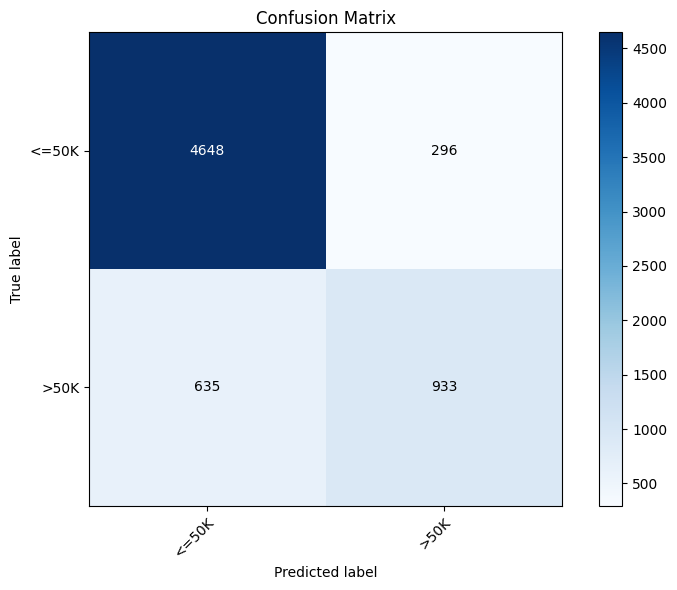

In [35]:
#Best estimator, confusion matrix, and classification report
##From: Class notes
# Get the best estimator from the search.
best_model = grid_search.best_estimator_

print("\n--- Best Model Found by GridSearchCV ---")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

print("\n Final evaluation of the best model on the test set...")
# Predict using the best model found during the search.
final_y_pred = best_model.predict(X_SVM_test)
final_accuracy = accuracy_score(y_SVM_test, final_y_pred)

print(f"Final accuracy on test set: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_SVM_test, final_y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_SVM_test, final_y_pred)
print(cm)

# Plot the predictions and the confusion matrix
plot_confusion_matrix(cm, y_SVM_test)

In [36]:
#Select just age and hours-per-week from X_SVM_train
X_SVM_train_2d = X_SVM_train[['age', 'capital-gain']]

Encoding string labels to numerical format...


/var/folders/lm/4kyv9_wd0dq69x6yy9fvmw5h0000gn/T/ipykernel_50203/2722965780.py:22: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_series = pd.Series(y).ravel()


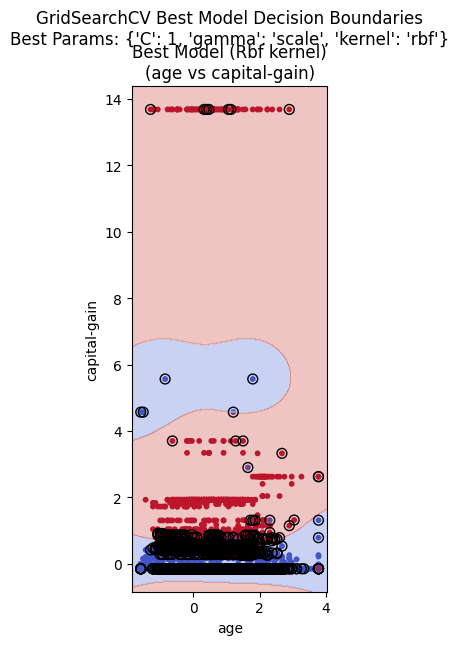

In [37]:
#Plot decision boundary for best SVM model
plot_best_svm_decision_boundary(grid_search, X_SVM_train_2d, y_SVM_train)

In [38]:
#Predicting on Validation Dataset using Best SVM Model

#Load validation dataset
validation_df = pd.read_csv("./data/processed_validation_inputs.csv")

#Get the training columns
train_columns = X_SVM_train.columns

#Reindex validation to match training columns. Fill missing with 0
#Fixes issue where validation doesn't contain the same one-hot encoded columns as training data
X_val_encoded = validation_df.reindex(columns=train_columns, fill_value=0)

#Ensure the order of columns matches
X_val_encoded = X_val_encoded[train_columns]

#Generate predictions using the trained SVM model
predictions = best_model.predict(X_val_encoded)

#Create a DataFrame with just index and predictions
output_df = pd.DataFrame({
    "Index": validation_df.index,
    "Predicted_Response": predictions
})

#Save to a new CSV file
output_df.to_csv("./predictions/Group_15_SVM_PredictedOutputs.csv", index=False)

#Report
print("Predictions saved to ./predictions/Group_15_SVM_PredictedOutputs.csv (index + prediction only)")

Predictions saved to ./predictions/Group_15_SVM_PredictedOutputs.csv (index + prediction only)


Encoding string labels to numerical format...


/var/folders/lm/4kyv9_wd0dq69x6yy9fvmw5h0000gn/T/ipykernel_50203/2722965780.py:22: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_series = pd.Series(y).ravel()


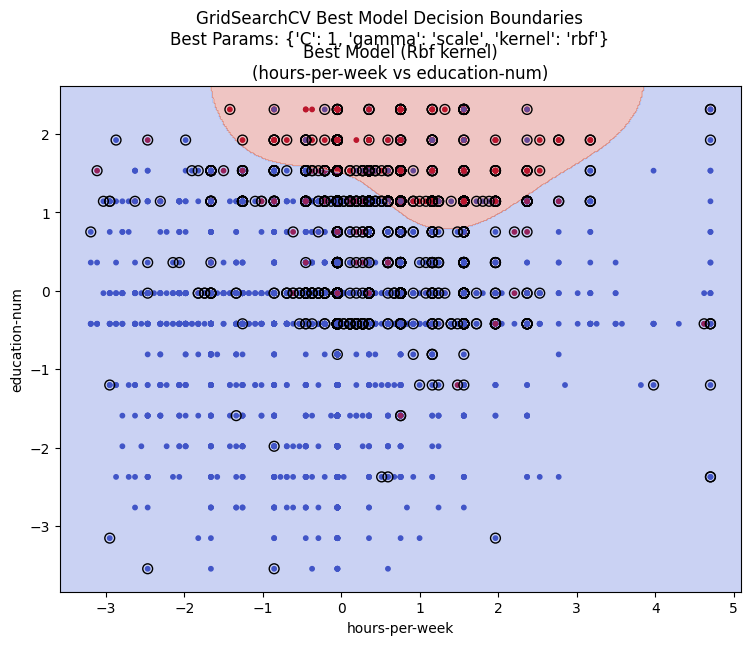

In [39]:
#Plot decision boundary on just 2 features from validation set
validation_2d = X_val_encoded[['hours-per-week', 'education-num']]
plot_best_svm_decision_boundary(grid_search, validation_2d, predictions)

In [40]:
#Run SVM model with different C values
C_values = [0.01, 1.0, 100.0]
print("Linear SVC Accuracy with different C values:")
for C in C_values:
    model = SVC(kernel='linear', C=C, random_state=221125)
    model.fit(X_SVM_train, y_SVM_train.values.ravel())
    y_pred = model.predict(X_SVM_test)
    acc = accuracy_score(y_SVM_test, y_pred)
    print(f"C={C:<6} -> Accuracy: {acc:.4f}")


Linear SVC Accuracy with different C values:
C=0.01   -> Accuracy: 0.8517
C=1.0    -> Accuracy: 0.8546
C=100.0  -> Accuracy: 0.8543


# Part 3: Comparison

In [41]:
#See how many predictions agree between LR and SVM models

#Load the model outputs
LR_outputs = pd.read_csv("./predictions/Group_15_LogisticRegression_PredictedOutputs.csv")
SVM_outputs = pd.read_csv("./predictions/Group_15_SVM_PredictedOutputs.csv")

# If both have an ID column, merge on it
# Otherwise, align by row index
df = pd.DataFrame({
    "LR_outputs": LR_outputs["Predicted_Response"],
    "SVM_outputs": SVM_outputs["Predicted_Response"]
})

# Compare predictions
df["agree"] = df["LR_outputs"] == df["SVM_outputs"]

# Count agreements
total = len(df)
agreements = df["agree"].sum()
disagreements = total - agreements
agreement_rate = agreements / total

print(f"Agreed on {agreements}/{total} ({agreement_rate:.2%})")
print(f"Disagreed on {disagreements}/{total}")


Agreed on 6246/6513 (95.90%)
Disagreed on 267/6513


Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /loky-50203-5s5ze9p0 for automatic cleanup: unknown resource type semlock
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /loky-50203-mdscspay for automatic cleanup: unknown resource type semlock
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} fo